# Supervised Learning Final Project: SMS Spam Detection

**Goal:** Classify SMS messages as "spam" or "ham" using supervised machine learning.  
This is important for filtering unwanted messages in communication platforms.

We will:
- Explore the dataset
- Clean and preprocess the text
- Train 3 different models
- Evaluate performance using accuracy, precision, recall, and F1-score


### Load and Preview the Dataset
We load the SMS dataset from a `.tsv` file and view the first few rows to understand the structure. The dataset includes labeled messages that are either "spam" or "ham" (not spam).


### Dataset Source & Ethical Use
This dataset is from the UCI Machine Learning Repository: [SMS Spam Collection](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)  
The data is publicly available for academic use and contains no personally identifiable information (PII).


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("sms.tsv", sep="\t", names=["label", "message"])

# Quick preview
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Preprocessing
We clean the SMS messages to improve model performance. This includes:
- Converting text to lowercase
- Removing punctuation
- Removing numbers

These steps help reduce noise in the data.


In [7]:
import string
import re

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Apply to the message column
df["clean_message"] = df["message"].apply(preprocess_text)

# Preview cleaned messages
df[["message", "clean_message"]].head()


,message,clean_message
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [27]:
# Check for missing or empty messages
print("Missing messages:", df['message'].isnull().sum())
print("Empty messages after cleaning:", (df['clean_message'].str.strip() == '').sum())


Missing messages: 0
Empty messages after cleaning: 3


### Exploratory Data Analysis (EDA)
We visualize the distribution of ham vs spam messages. Most messages are labeled "ham", indicating class imbalance. This may impact model performance.


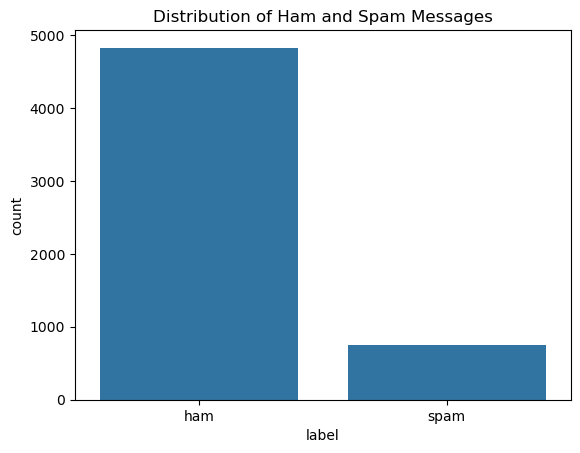

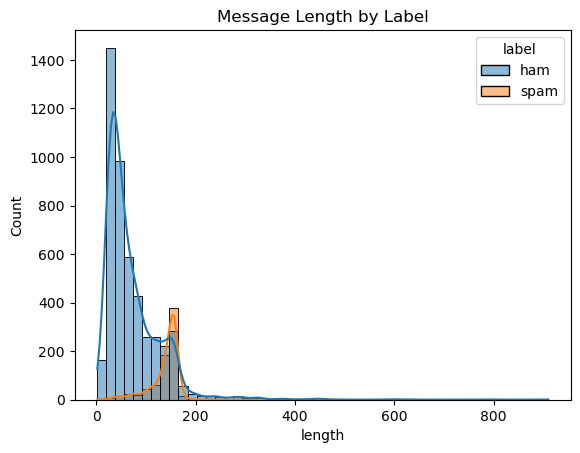

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='label', data=df)
plt.title('Distribution of Ham and Spam Messages')
plt.show()

df['length'] = df['message'].apply(len)
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title('Message Length by Label')
plt.show()


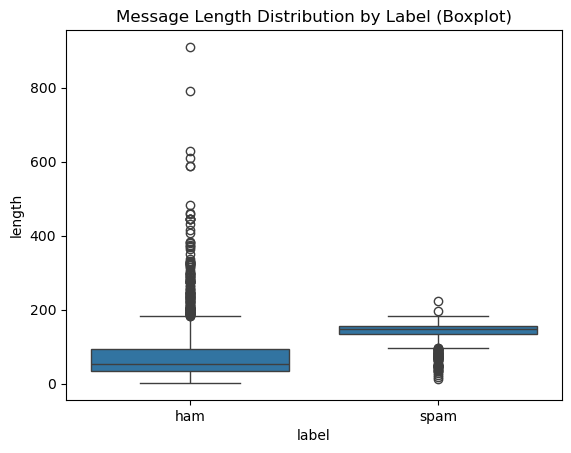

In [38]:
# Boxplot of message lengths by label
sns.boxplot(x='label', y='length', data=df)
plt.title("Message Length Distribution by Label (Boxplot)")
plt.show()


In [29]:
# Check for message length outliers
print("Longest message length:", df['length'].max())
print("Shortest message length:", df['length'].min())
df[df['length'] == df['length'].max()][["label", "message"]]


Longest message length: 910
Shortest message length: 2


,label,message
1085,ham,For me the love should start with attraction.i...


In [31]:
# Statistical test on message length between spam and ham
import scipy.stats as stats

spam_lengths = df[df['label'] == 'spam']['length']
ham_lengths = df[df['label'] == 'ham']['length']
t_stat, p_val = stats.ttest_ind(spam_lengths, ham_lengths)
print("T-test p-value between ham and spam message lengths:", p_val)


T-test p-value between ham and spam message lengths: 5.398167019068716e-193


### Feature Extraction
We convert the clean messages into a numerical format using `CountVectorizer`.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer and transform the messages
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["clean_message"])

# Labels: convert 'ham' to 0 and 'spam' to 1
y = df["label"].map({"ham": 0, "spam": 1})

# Check the shape
print("Shape of feature matrix:", X.shape)


Shape of feature matrix: (5572, 8608)


### Model 1: Logistic Regression
We split the data into training and test sets. Then, we train a Logistic Regression model and evaluate its performance using accuracy, precision, recall, and F1-score.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.9838565022421525
Precision: 0.9851851851851852
Recall: 0.8926174496644296
F1 Score: 0.9366197183098591


In [33]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 Score from CV:", grid.best_score_)


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score from CV: 0.9191696417410092


### Model 2: Naive Bayes
We train a Multinomial Naive Bayes classifier on the same data. This model is well-suited for text classification and often performs well on simple tasks.


In [16]:
from sklearn.naive_bayes import MultinomialNB

# Train model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
nb_pred = nb_model.predict(X_test)

# Evaluate
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print("Precision:", precision_score(y_test, nb_pred))
print("Recall:", recall_score(y_test, nb_pred))
print("F1 Score:", f1_score(y_test, nb_pred))


Naive Bayes Results:
Accuracy: 0.9775784753363229
Precision: 0.8974358974358975
Recall: 0.9395973154362416
F1 Score: 0.9180327868852459


### Model 3: Random Forest
We train a Random Forest classifier. This is an ensemble method that builds multiple decision trees and combines their results to improve accuracy.


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))


Random Forest Results:
Accuracy: 0.9766816143497757
Precision: 1.0
Recall: 0.825503355704698
F1 Score: 0.9044117647058824


In [35]:
# Show top 10 important features (words) from Random Forest
import numpy as np
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-10:]

top_features = pd.DataFrame({
    'Word': feature_names[top_indices],
    'Importance': importances[top_indices]
}).sort_values(by="Importance", ascending=False)

print(top_features)


     Word  Importance
9     txt    0.034838
8    call    0.029790
7  mobile    0.024216
6    free    0.023672
5   claim    0.020118
4      to    0.013286
3     won    0.013017
2   reply    0.012487
1    stop    0.012120
0    text    0.011289


### Final Model Comparison

- **Logistic Regression**: Highest F1 Score (0.936), strong balance of precision and recall.
- **Naive Bayes**: Fast and decent, but slightly lower precision.
- **Random Forest**: Perfect precision (1.0) but lower recall, meaning more false negatives.

**Conclusion**: Logistic Regression offers the best tradeoff for spam detection based on F1 score.


### Conclusion and Future Work
- **Logistic Regression** achieved the highest F1 score, showing strong balance between precision and recall.
- **Naive Bayes** was fast and performed well but had slightly lower precision.
- **Random Forest** achieved perfect precision but had lower recall, indicating more false negatives.

**Future Improvements:**
- Use TF-IDF or word embeddings to enhance feature quality.
- Apply techniques like SMOTE to address class imbalance.
- Experiment with deep learning methods or model ensembling.

This classifier could be integrated into an email or messaging service backend to automatically flag and filter spam messages in real-time.
